In [1]:
import kdshmap as kd
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [ ]:
# 

In [2]:
tmon_dim = 2
wq = 4 ## transmon 0-1 frequency
alpha = -0.3 ## anharmonicity
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
n = q.destroy(tmon_dim)+q.create(tmon_dim)
f_list = np.linspace(-10,10,2001)
Sf_list = 1 * np.linspace(0.01,0.01,2001)
gamma = 0.05*2*np.pi
g = 0.01*2*np.pi
wt = 3.85
Sf_list = gamma/((gamma/2)**2+(f_list-wt)**2*4*np.pi**2) * g**2 
#Sf_list = np.ones(len(f_list))*0.00125
t_list = np.linspace(0,200,50001)
env = np.exp(-(t_list-t_list[-1]/2)**2/(t_list[-1]/2)**2)
env = env - np.min(env)
drive_list =   2*np.pi*0.3*np.cos(2*np.pi*(wq+0.00)*t_list) * env
#plt.plot(t_list, drive_list)
H = [H, [n, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

#q.propagator(H, t_list)

In [3]:
t_list = np.linspace(0,200,50001)
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
H = [H, [n, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

t_list = np.linspace(0,200,401)
minimal_step = 1/100

In [7]:
import kdshmap as kd
solver = kd.KeldyshSolver(H,t_list,minimal_step,[n],
                          [f_list],[Sf_list],
                          trunc_freq=[(3.4,4.5)],
                          density0 = (q.basis(tmon_dim,1)
                                      *q.basis(tmon_dim,1).dag()), 
                          e_ops=[(q.basis(tmon_dim,1)
                                  *q.basis(tmon_dim,1).dag())], 
                          method='trapz',goal='expect')

In [4]:
import kdshmap as kd
solver = kd.KeldyshSolver(H,t_list,minimal_step,n,
                          f_list,Sf_list,
                          trunc_freq=(3.4,4.5),
                          density0 = (q.basis(tmon_dim,1)
                                      *q.basis(tmon_dim,1).dag()), 
                          e_ops=[(q.basis(tmon_dim,1)
                                  *q.basis(tmon_dim,1).dag())], 
                          method='trapz',goal='expect')

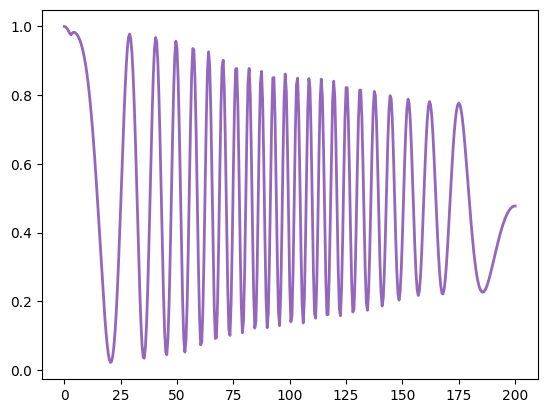

In [5]:
%matplotlib inline
plt.plot(t_list, solver.expect[0].real, 'C4', lw = 2)
#plt.plot(t_list_full, ms_result.expect[0], 'k--', alpha = 1, lw = 1)

In [9]:
solver2 = kd.KeldyshSolver(H,t_list,minimal_step,[n,n],
                       [f_list,f_list],[Sf_list,Sf_list],trunc_freq=[(-5,5),(-5,5)],density0 = q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag(), 
                       e_ops=[q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag()], method='trapz',goal='expect')

<IPython.core.display.Javascript object>


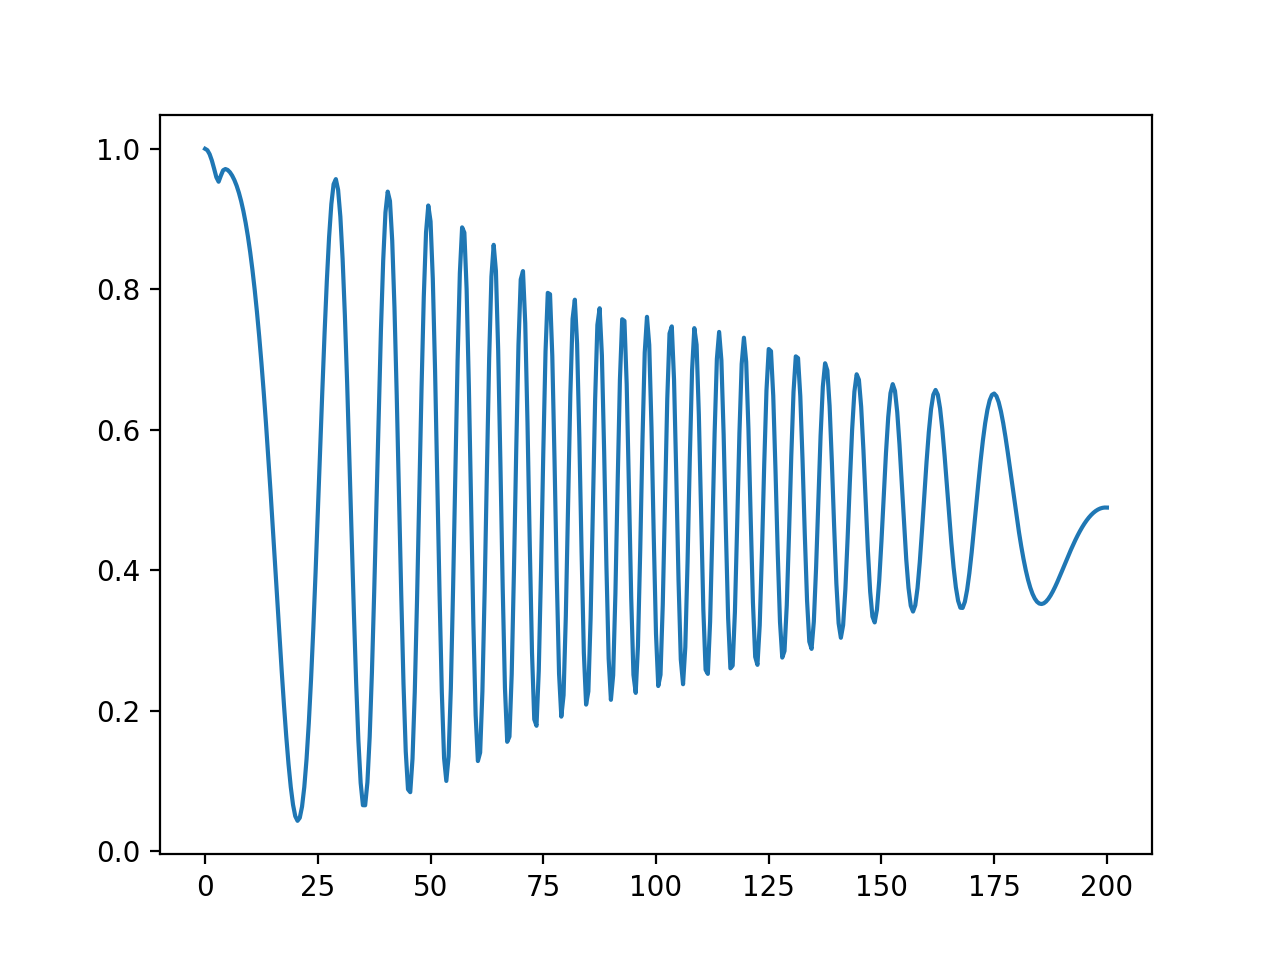

In [10]:
plt.plot(t_list, solver2.expect[0].real)

In [6]:
t_list = np.linspace(0,200,50001)
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
H = [H, [n, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]


<Axes: xlabel='frequency (unit of time$^{-1}$)', ylabel='filter strength'>

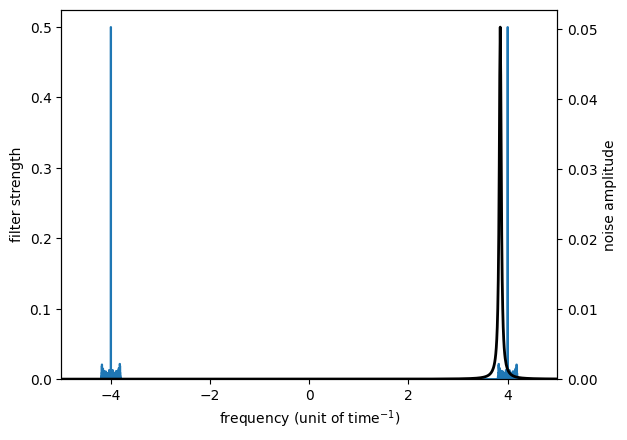

In [7]:
kd.plot_filter_Sf(H,t_list,n,f_list,Sf_list,trunc_freq=(-5,5))

array([<Axes: xlabel='frequency (unit of time$^{-1}$)', ylabel='filter strength'>,
       <Axes: xlabel='frequency (unit of time$^{-1}$)', ylabel='filter strength'>],
      dtype=object)

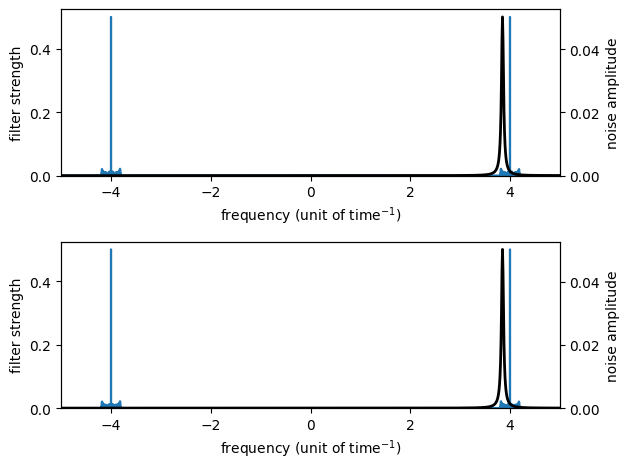

In [8]:
kd.plot_filter_Sf_multiple(H,t_list,[n,n],[f_list,f_list],[Sf_list,Sf_list],trunc_freq_list=[(-5,5), (-5,5)])

In [9]:
np.array([None])

array([None], dtype=object)

ValueError: x and y must have same first dimension, but have shapes (401,) and (50001,)

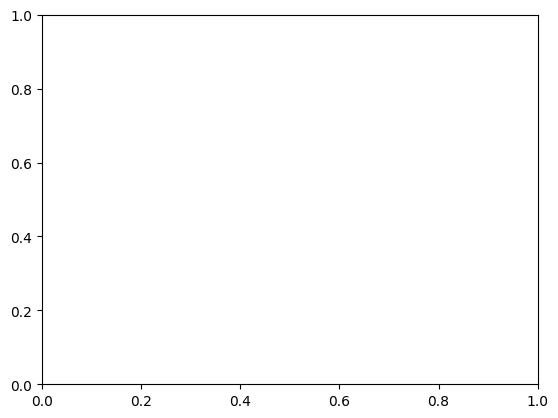

In [6]:
plt.plot(t_list, drive_list)

In [7]:
t_list_full = np.linspace(0,200,50001)
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
H = [H, [n, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

t_list = np.linspace(0,200,401)
minimal_step = 1/100


In [4]:
solver = kd.KeldyshSolver(H,t_list,minimal_step,n,
                       f_list,Sf_list,trunc_freq=(-5,5),density0 = q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag(), 
                       e_ops=[q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag()], method='trapz',goal='expect')


(0.0, 1.0)

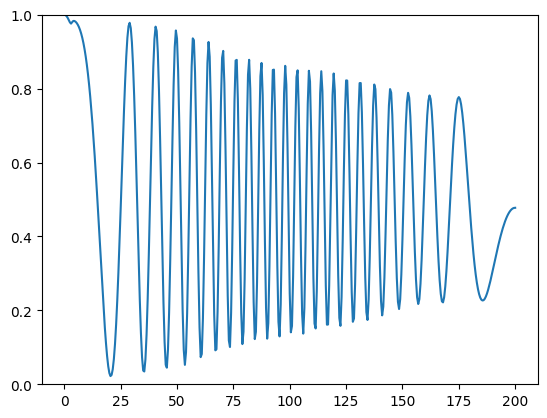

In [5]:
plt.plot(t_list, solver.expect[0].real)
plt.ylim(0.0,1)

In [3]:
t_list = np.linspace(0,200,50001)
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
H = [H, [n, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

t_list = np.linspace(0,200,401)
minimal_step = 1/100

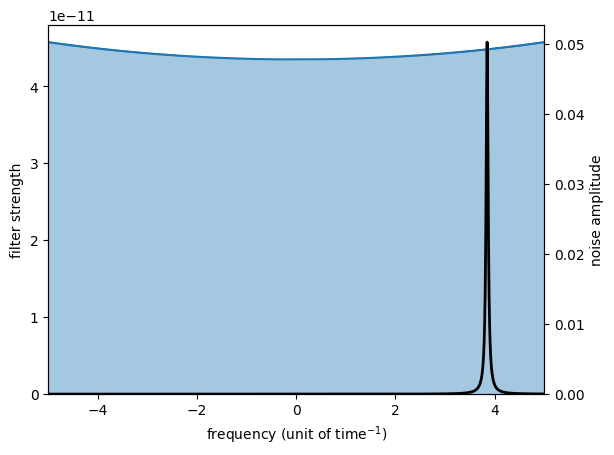

In [4]:
solver = kd.KeldyshSolver(H,t_list,minimal_step,n,
                       f_list,Sf_list,trunc_freq=(-5,5),density0 = q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag(), 
                       e_ops=[q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag()], method='trapz',goal='filter')
#plt.plot(t_list, solver.expect[0].real)

In [5]:
max(solver.filter_strength)

4.57534199025581e-11

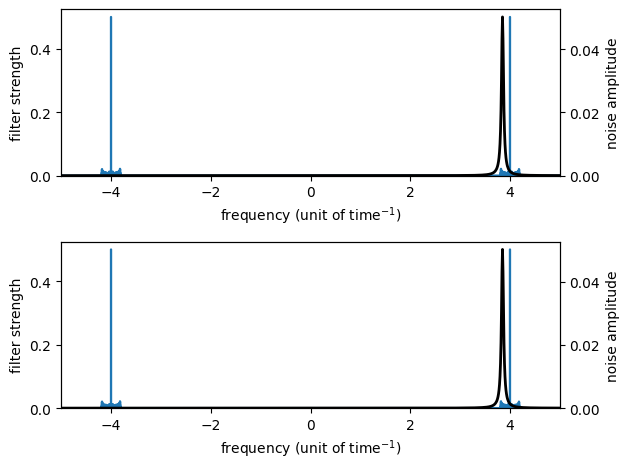

In [6]:
solver = kd.KeldyshSolver(H,t_list,minimal_step,[n,n],
                       [f_list,f_list],[Sf_list,Sf_list],trunc_freq=[(-5,5),(-5,5)],density0 = q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag(), 
                       e_ops=[q.basis(tmon_dim,1)*q.basis(tmon_dim,1).dag()], method='trapz',goal='filter')
#plt.plot(t_list, solver.expect[0].real)

# Let's work out an example

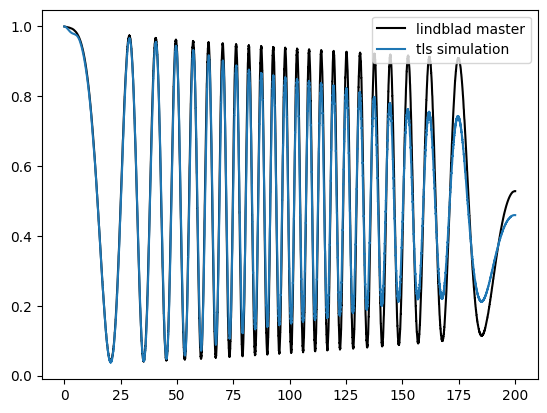

In [238]:
# comparison

H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
I_q = q.qeye(tmon_dim)
n = q.destroy(tmon_dim)+q.create(tmon_dim)
f_list = np.linspace(-10,10,1001)
Sf_list = 1 * np.linspace(0.01,0.01,1001)
#Sf_list = gamma/(gamma*2+(f_list-3.85)**2) * 0.3
t_list = np.linspace(0,200,50001)
#H = [H, [n, q.interpolate.Cubic_Spline(0,200, 2*np.pi*0.1*np.cos(2*np.pi*(wq+0.005)*t_list))]]
H_tls = - wt/2 * q.sigmaz() * 2*np.pi
I_tls = q.qeye(2)
H = q.tensor(H, I_tls) + q.tensor(I_q, H_tls)
H_int = g * q.tensor(n, q.sigmax())
H += H_int *0
psi0 = q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), q.basis(tmon_dim, 0)*q.basis(tmon_dim, 0).dag())
n_full = q.tensor(n, I_tls)
sm = q.tensor(I_q, q.destroy(2))
H = [H, [n_full, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

ms_result_lindblad = q.mesolve(H, psi0, t_list, c_ops=[np.sqrt(0.00135)*q.tensor(q.destroy(tmon_dim), I_tls)], 
                      e_ops=[q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), I_tls)],
                     options = q.Options(rtol = 1e-10, atol = 1e-10))

H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
H = q.tensor(H, I_tls) + q.tensor(I_q, H_tls)
H += H_int 
H = [H, [n_full, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]
ms_result_true = q.mesolve(H, psi0, t_list, c_ops=[np.sqrt(gamma)*sm], 
                      e_ops=[q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), I_tls)],
                     options = q.Options(rtol = 1e-10, atol = 1e-10))

plt.plot(t_list, ms_result_lindblad.expect[0], 'k', label = 'lindblad master')
plt.plot(t_list, ms_result_true.expect[0], label = 'tls simulation')
plt.legend()
t_list = np.linspace(0,200,401)
#plt.plot(t_list, result2[0].real)


NameError: name 'ms_result_lindblad' is not defined

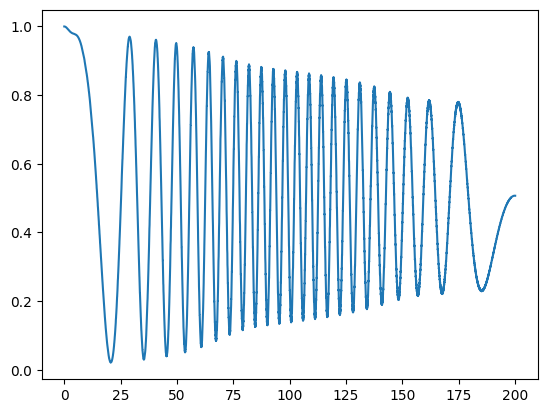

In [5]:
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
I_q = q.qeye(tmon_dim)
n = q.destroy(tmon_dim)+q.create(tmon_dim)
f_list = np.linspace(-10,10,1001)
Sf_list = 1 * np.linspace(0.01,0.01,1001)
#Sf_list = gamma/(gamma*2+(f_list-3.85)**2) * 0.3
t_list = np.linspace(0,200,50001)
#H = [H, [n, q.interpolate.Cubic_Spline(0,200, 2*np.pi*0.1*np.cos(2*np.pi*(wq+0.005)*t_list))]]
H_tls = - wt/2 * q.sigmaz() * 2*np.pi
I_tls = q.qeye(2)
H = q.tensor(H, I_tls) + q.tensor(I_q, H_tls)
H_int = g * q.tensor(n, q.sigmax())
H += H_int
psi0 = q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), q.basis(tmon_dim, 0)*q.basis(tmon_dim, 0).dag())
n_full = q.tensor(n, I_tls)
sm = q.tensor(I_q, q.destroy(2))
H = [H, [n_full, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

ms_result = q.mesolve(H, psi0, t_list, c_ops=[np.sqrt(gamma)*sm], e_ops=[q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), I_tls)],
                     options = q.Options(rtol = 1e-10, atol = 1e-10))
plt.plot(t_list, ms_result.expect[0])
plt.plot(t_list, ms_result_lindblad.expect[0], 'k-')
t_list = np.linspace(0,200,401)
plt.plot(t_list, result[0].real, '--')


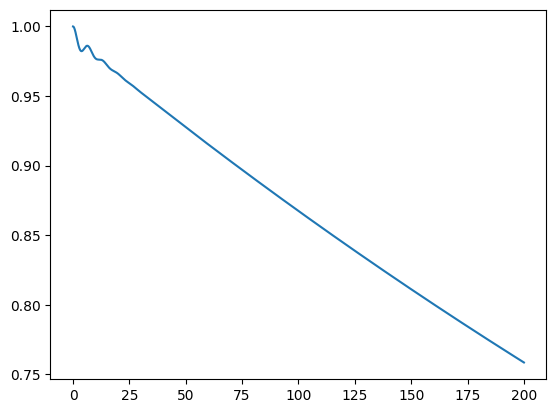

In [223]:
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)) * 2 * np.pi
I_q = q.qeye(tmon_dim)
n = q.destroy(tmon_dim)+q.create(tmon_dim)
f_list = np.linspace(-10,10,1001)
Sf_list = 1 * np.linspace(0.01,0.01,1001)
#Sf_list = gamma/(gamma*2+(f_list-3.85)**2) * 0.3
t_list = np.linspace(0,200,50001)
#H = [H, [n, q.interpolate.Cubic_Spline(0,200, 2*np.pi*0.1*np.cos(2*np.pi*(wq+0.005)*t_list))]]
H_tls = - wt/2 * q.sigmaz() * 2*np.pi
I_tls = q.qeye(2)
H = q.tensor(H, I_tls) + q.tensor(I_q, H_tls)
H_int = g * q.tensor(n, q.sigmax())
H += H_int
psi0 = q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), q.basis(tmon_dim, 0)*q.basis(tmon_dim, 0).dag())
n_full = q.tensor(n, I_tls)
sm = q.tensor(I_q, q.destroy(2))
#H = [H, [n_full, q.interpolate.Cubic_Spline(0, t_list[-1], drive_list)]]

ms_result = q.mesolve(H, psi0, t_list, c_ops=[np.sqrt(gamma)*sm], e_ops=[q.tensor(q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(), I_tls)],
                     options = q.Options(rtol = 1e-10, atol = 1e-10))
plt.plot(t_list, ms_result.expect[0])
#plt.plot(t_list, ms_result_lindblad.expect[0], 'k-')
#t_list = np.linspace(0,200,401)
#plt.plot(t_list, result[0].real, '--')


In [34]:
# now we have fft for the whole time duration -- can we construct 0~x T with 0<x<1?
def filter(x):
    return np.sinc(x) + x/2 * (np.sinc(x/2))**2/1j



def fft_sub(t_list, fft, fft_freq, t, f_trunc):
    fp = 1/abs(t_list[-1])
    fp_new = 1/abs(t)
    f_list_new = np.arange(np.floor(f_trunc[0]/fp_new), np.ceil(f_trunc[1]/fp_new)) * fp_new
    
    Nf_keep = np.ceil(15/(2*np.pi*t*fp))
    fft_map = np.zeros((len(f_list_new)), dtype = complex)
    for j in range(len(f_list_new)):
        freq_diff = fft_freq - f_list_new[j]
        index = np.where(np.logical_and(freq_diff >= -Nf_keep*fp, freq_diff <= Nf_keep*fp))
        fft_map[j] = np.dot(filter(2*freq_diff[index]*t), fft[index])
    return fft_map, f_list_new

In [254]:
# Draw a figure

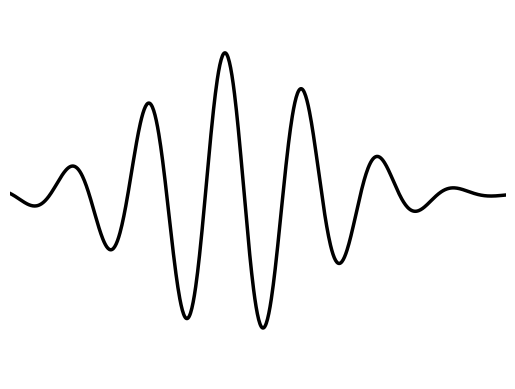

In [292]:
import matplotlib.pyplot as plt
import numpy as np
t_list = np.linspace(0, 1, 1001)
y = np.exp(-(t_list-t_list[-1]/2)**2/(t_list[-1]/5.0)**2)
y = y - np.amin(y)
y = y * np.cos(2*np.pi*t_list*8.2)
plt.plot(t_list, y, lw = 2.5, color = 'k')
plt.ylim(-1.3, 1.3)
plt.xlim(0.15, 0.93)

plt.axis('off')
plt.savefig('cosine.pdf', dpi = 1000)